# Simulation of what calculate_autolock_instructions does

## Import useful libraries

This imports directly from the RedPitaya all the useful libraries to be sure that we are looking at what the RP actually does. 

In [59]:
from paramiko import SSHClient
from scp import SCPClient

hostname = '192.168.1.159'
username = 'root'
password = 'root'

local_path = '/home/bec3/Desktop/Simone_Damian/Serafini/Test_calculate_autolock_instructions'
remote_paths = ['/usr/local/lib/python3.10/dist-packages/linien_server', '/usr/local/lib/python3.10/dist-packages/linien_common']
ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect(hostname, username = username, password = password)

for remote_path in remote_paths:
    # Create SCP client
    with SCPClient(ssh.get_transport()) as scp:
        scp.get(remote_path, local_path, recursive=True)

ssh.close()

## Libraries

In [60]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
from linien_server.autolock.robust import calculate_autolock_instructions,get_lock_position_from_autolock_instructions
from linien_server.autolock.utils import crop_spectra_to_same_view,sum_up_spectrum,get_diff_at_time_scale,get_time_scale,get_all_peaks,get_lock_region,get_target_peak,get_all_peaks_v2,get_lock_region_v2
import numpy as np
import matplotlib
if not hasattr(matplotlib.RcParams, "_get"):
    def _get(self, key):
        return self[key]
    matplotlib.RcParams._get = _get
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import correlate
from time import time
import subprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing from RedPitaya

In [91]:
#Locations of robust_spectra
remote_user = "root"
remote_ip = "192.168.1.159"
remote_path = "/root/.local/share/linien/robust_spectra.npy"
local_path = "/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files"
key_path = "~/.ssh/rp_TN"

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)

#Locations of target_idxs
remote_user = "root"
remote_ip = "192.168.1.159"
remote_path = "/root/.local/share/linien/target_idxs.npy"
local_path = "/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files"
key_path = "~/.ssh/rp_TN"

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)


CompletedProcess(args=['scp', '-i', '~/.ssh/rp_TN', 'root@192.168.1.159:/root/.local/share/linien/target_idxs.npy', '/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files'], returncode=0)

## Load and crop

--- spectra properties ---
spectra shape:  (5, 2048)
spectra : 
 [[-3  1  1 ... -6 -6 -6]
 [-2  1  1 ... -5 -5 -5]
 [-2  1  2 ... -5 -5 -5]
 [-2  3  2 ... -5 -5 -5]
 [-1  2  2 ... -5 -5 -5]]
Number of spectra: 5

--- idxs properties ---
target_idxs shape:  (2,)
target_idxs: 
 [1701 1741]
--- spectra_cropped properties ---
spectra_cropped shape: 
 (5, 2036)
spectra_cropped: 
 [[-3  1  1 ... -7 -7 -7]
 [ 2  2  3 ... -5 -5 -5]
 [ 2  2  2 ... -5 -5 -5]
 [ 3  3  2 ... -5 -5 -5]
 [ 3  3  4 ... -5 -5 -5]]

--- crop_left properties ---
crop_left: 
 0
time_scale 30
shift 13


[]

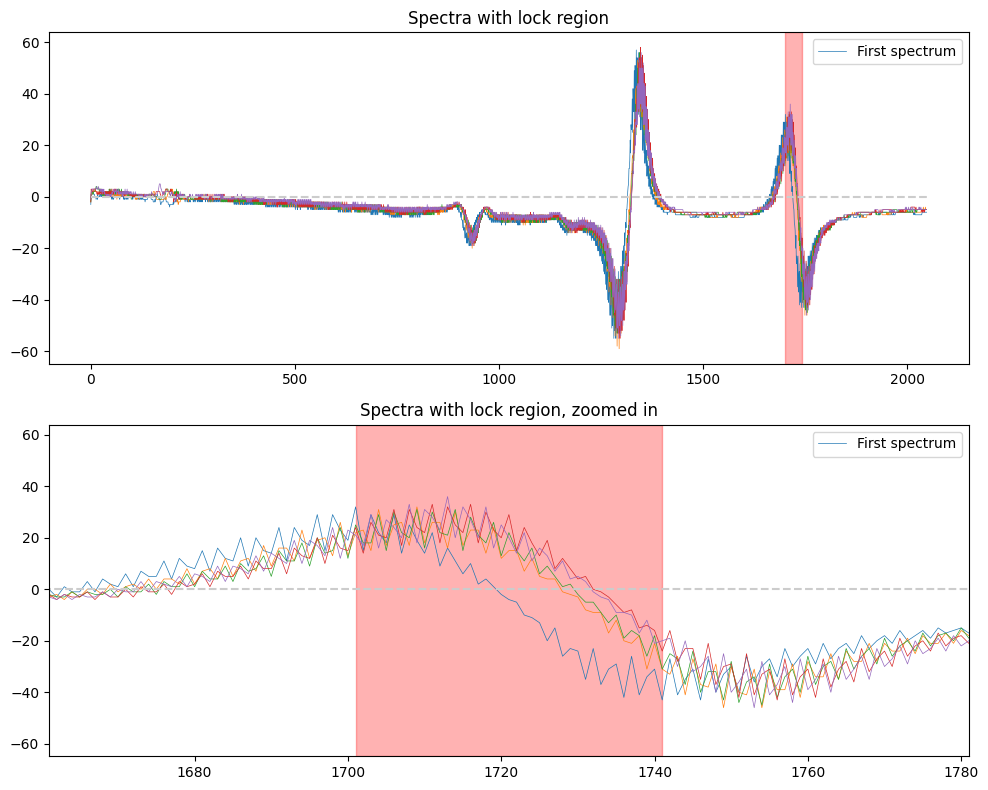

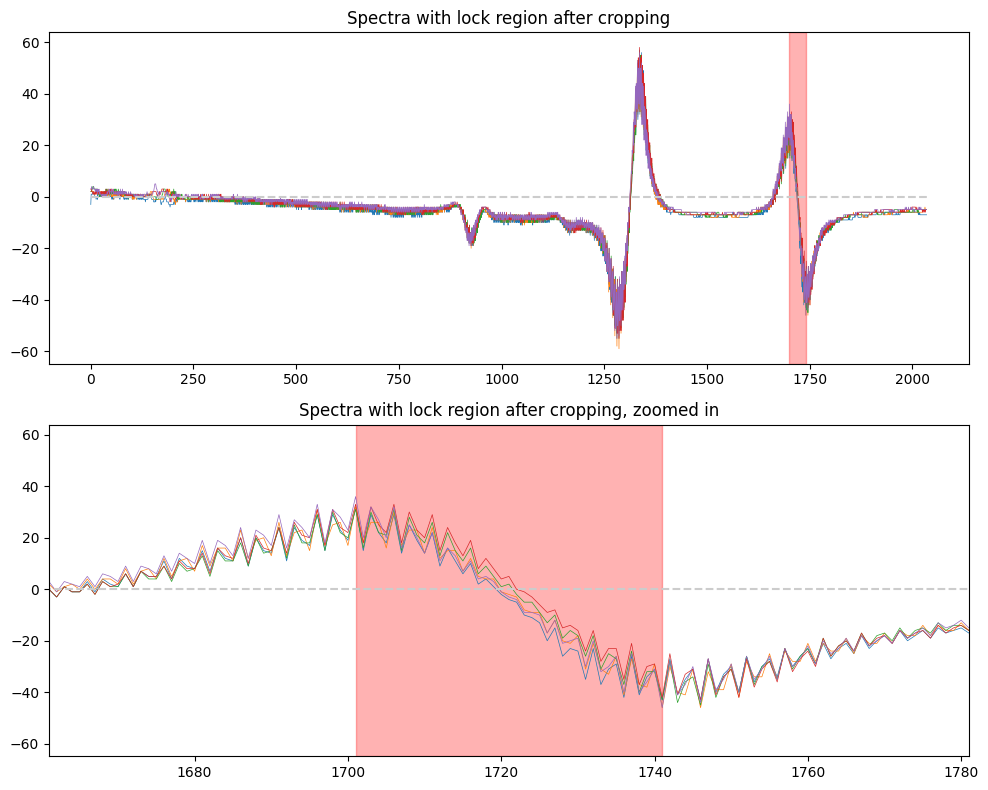

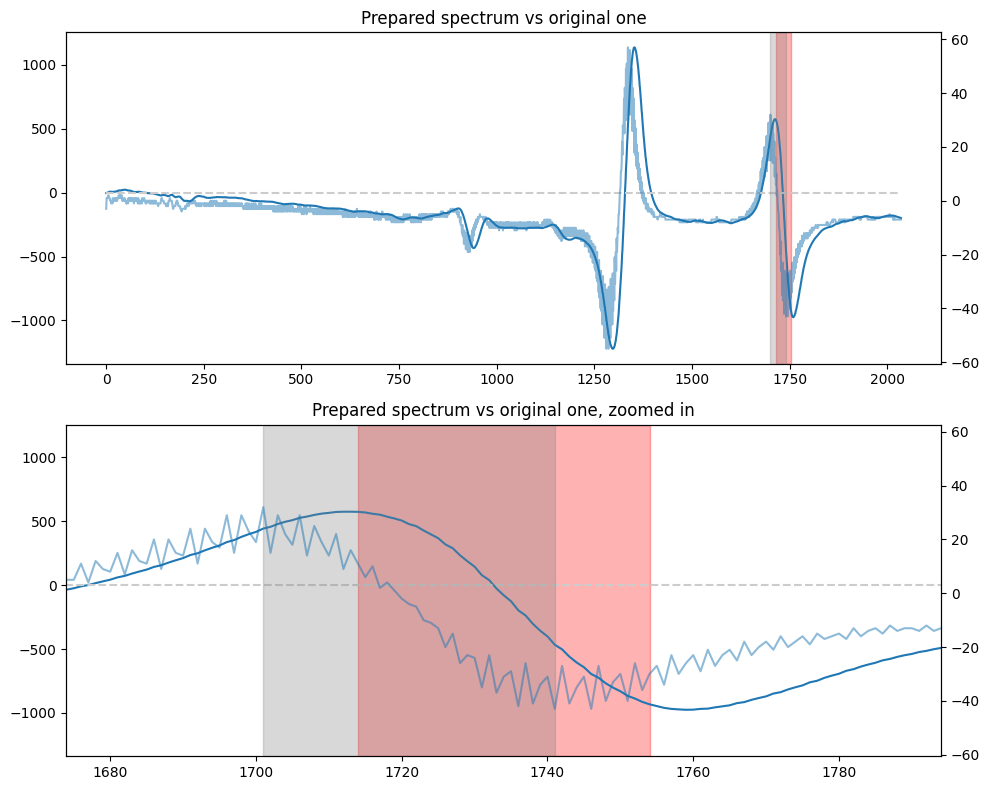

In [92]:
# -- Load and print properties of the files --

print("--- spectra properties ---")
spectra = np.load('/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files/robust_spectra.npy')
print("spectra shape: ", spectra.shape)
print("spectra : \n", spectra)
N_SPECTRA = spectra.shape[0]
print(f"Number of spectra: {N_SPECTRA}")

print("\n--- idxs properties ---")
target_idxs = np.load('/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files/target_idxs.npy')
print("target_idxs shape: ", target_idxs.shape)
print("target_idxs: \n", target_idxs)

# -- Plot the spectra and the locking region --

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

for i in range(N_SPECTRA):
    if i == 0:
        axs[0].plot(spectra[i], lw=0.5, label = 'First spectrum')
    else:
        axs[0].plot(spectra[i], lw=0.5)

x0 = target_idxs[0]
x1 = target_idxs[1]
axs[0].hlines(0, 0, spectra.shape[1], color = '0.8', ls = '--')
axs[0].axvspan(x0, x1, color='red', alpha=0.3)
axs[0].set_title('Spectra with lock region')
axs[0].legend()

#Zoom to highlight the jitter
for i in range(N_SPECTRA):
    if i == 0:
        axs[1].plot(spectra[i], lw=0.5, label = 'First spectrum')
    else:
        axs[1].plot(spectra[i], lw=0.5)

x0 = target_idxs[0]
x1 = target_idxs[1]
window_width = x1 - x0
axs[1].hlines(0, 0, spectra.shape[1], color = '0.8', ls = '--')
axs[1].axvspan(x0, x1, color='red', alpha=0.3)
axs[1].set_title('Spectra with lock region, zoomed in')
axs[1].set_xlim(x0-window_width, x1+window_width)
axs[1].legend()

plt.tight_layout()
plt.plot()

# -- Plot the cropped spectra and the locking region --
target_idxs = (x0,x1)

spectra_cropped, crop_left = crop_spectra_to_same_view(spectra) #ORIGINAL CODE
spectra_cropped = np.array(spectra_cropped)

print("--- spectra_cropped properties ---")
print("spectra_cropped shape: \n", spectra_cropped.shape)
print("spectra_cropped: \n", spectra_cropped)

print("\n--- crop_left properties ---")
print("crop_left: \n", crop_left)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

for i in range(N_SPECTRA):
    axs[0].plot(spectra_cropped[i], lw=0.5)

target_idxs = [idx - crop_left for idx in target_idxs] #ORIGINAL CODE

axs[0].hlines(0, 0, spectra_cropped.shape[1], color = '0.8', ls = '--')
axs[0].axvspan(target_idxs[0], target_idxs[1], color='red', alpha=0.3)
axs[0].set_title('Spectra with lock region after cropping')

for i in range(N_SPECTRA):
    axs[1].plot(spectra_cropped[i], lw=0.5)

window_width_cropped = target_idxs[1] - target_idxs[0]
axs[1].hlines(0, 0, spectra_cropped.shape[1], color = '0.8', ls = '--')
axs[1].axvspan(target_idxs[0], target_idxs[1], color='red', alpha=0.3)
axs[1].set_xlim(target_idxs[0] - window_width_cropped, target_idxs[1] + window_width_cropped)
axs[1].set_title('Spectra with lock region after cropping, zoomed in')

plt.tight_layout()
plt.plot()

time_scale = int(round(np.mean([get_time_scale(spectrum, target_idxs) for spectrum in spectra])))
print('time_scale', time_scale) #ORIGINAL CODE

prepared_spectrum = get_diff_at_time_scale(sum_up_spectrum(spectra_cropped[0]), time_scale) #ORIGINAL CODE

shift_prepared = np.argmax(correlate(prepared_spectrum, spectra_cropped[0]))-len(prepared_spectrum)
print('shift', shift_prepared) #ADDED CODE. This shift is needed to realign the target idxs after preparation.

target_idxs_prepared = [idx + shift_prepared for idx in target_idxs] #ADDED CODE. Adjust target idxs after preparation.

#--- prepared spectrum plot ---

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

ax0 = axs[0] # Primary y-axis
ax1 = ax0.twinx() # Secondary y-axis

ax0.plot(prepared_spectrum)
ax1.plot(spectra_cropped[0], alpha=0.5)

ax0.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
ax1.axvspan(target_idxs[0], target_idxs[1], color='grey', alpha=0.3)
ax0.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
ax0.set_title('Prepared spectrum vs original one')

ax2 = axs[1] # Primary y-axis
ax3 = ax2.twinx() # Secondary y-axis

ax2.plot(prepared_spectrum)
ax3.plot(spectra_cropped[0], alpha=0.5)

window_width_cropped_prepared = target_idxs_prepared[1] - target_idxs_prepared[0]
ax2.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
ax3.axvspan(target_idxs[0], target_idxs[1], color='grey', alpha=0.3)
ax2.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
ax2.set_xlim(target_idxs_prepared[0] - window_width_cropped_prepared, target_idxs_prepared[1] + window_width_cropped_prepared)
ax2.set_title('Prepared spectrum vs original one, zoomed in')

plt.tight_layout()
plt.plot()

first peak is in  1714  with value  574
y_scale 574
peaks [(1714, 574), (1601, -239), (1353, 1137), (1298, -1221), (50, 23), (0, -3)]


[]

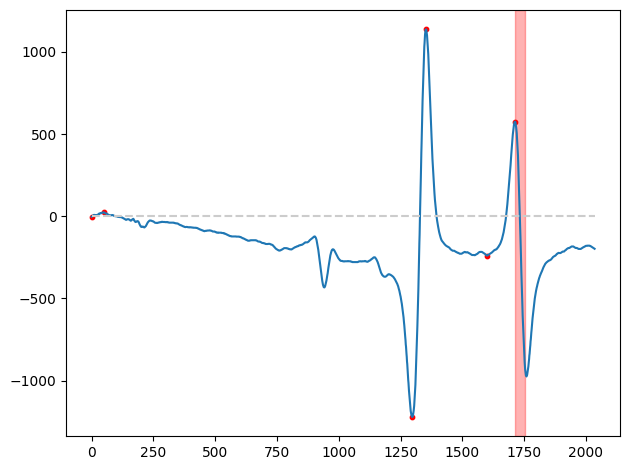

In [93]:
peaks = get_all_peaks_v2(prepared_spectrum, target_idxs_prepared) #MODIFIED CODE. Using v2 to get peaks on prepared spectrum.
y_scale = peaks[0][1] #ORIGINAL CODE

print('y_scale', y_scale)

print('peaks', peaks)
plt.plot(prepared_spectrum)
plt.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
plt.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
for peak_position,peak_value in peaks:
    plt.scatter(peak_position, peak_value, color='red',s=10)

plt.tight_layout()
plt.plot()

lock_regions [(1674, 1752), (1674, 1752), (1674, 1754), (1674, 1754), (1674, 1752)]


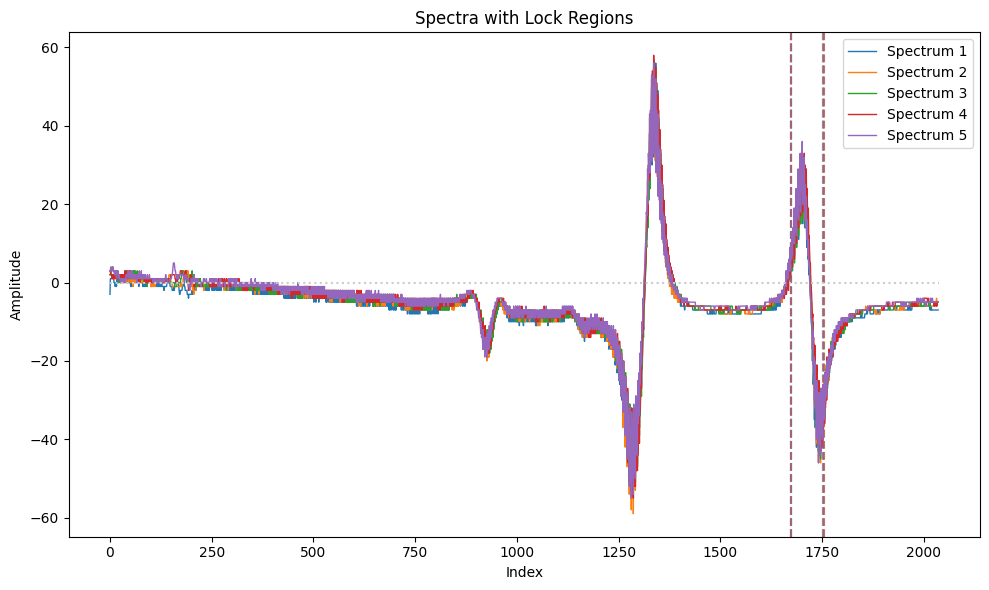

In [94]:
lock_regions = [get_lock_region_v2(spectrum, target_idxs, prepared_spectrum) for spectrum in spectra_cropped] #MODIFIED CODE. Using v2 to get lock regions on cropped spectra based on prepared spectrum.

print('lock_regions', lock_regions)

fig, ax = plt.subplots(figsize=(10, 6))

# Use Matplotlib's default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (spectrum, lock_region) in enumerate(zip(spectra_cropped, lock_regions)):
    color = colors[i % len(colors)]
    ax.plot(spectrum, lw=1, color=color, label=f"Spectrum {i+1}")

    # Handle both range (x0, x1) or single value lock region
    if isinstance(lock_region, (list, tuple, np.ndarray)) and len(lock_region) == 2:
        x0, x1 = lock_region
        ax.axvline(x0, color=color, ls='--', alpha=0.5)
        ax.axvline(x1, color=color, ls='--', alpha=0.5)
        #ax.axvspan(x0, x1, color=color, alpha=0.1)
    else:
        ax.axvline(lock_region, color=color, ls='--', alpha=0.5)

ax.hlines(0, 0, spectra_cropped.shape[1], color='0.8', ls=':')
ax.set_title("Spectra with Lock Regions")
ax.set_xlabel("Index")
ax.set_ylabel("Amplitude")
ax.legend()
plt.tight_layout()
plt.show()

--- tolerance factor 0.95
original peaks [(1714, 574), (1601, -239), (1353, 1137), (1298, -1221), (50, 23), (0, -3)]
peaks filtered [(1714, 545.3), (1601, -227.04999999999998), (1353, 1080.1499999999999), (1298, -1159.95)]
target peak idx 1714
final wait time 7
description is [(1168, -1159), (49, 1080), (223, -227), (101, 545)]
lock_position 1715


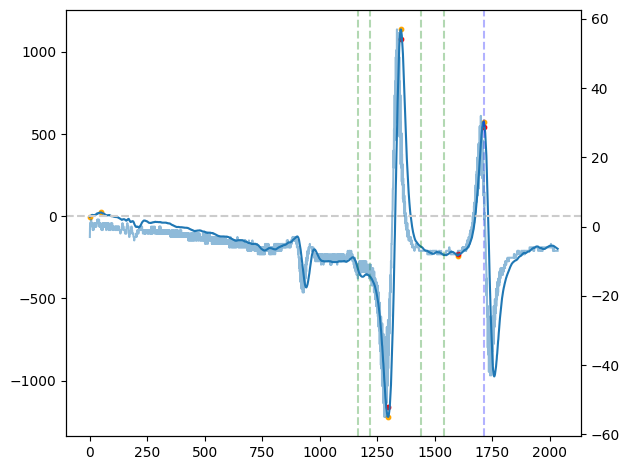

--- tolerance factor 0.9
original peaks [(1714, 574), (1601, -239), (1353, 1137), (1298, -1221), (50, 23), (0, -3)]
peaks filtered [(1714, 516.6), (1601, -215.1), (1353, 1023.3000000000001), (1298, -1098.9)]
target peak idx 1714
final wait time 9
description is [(1168, -1098), (49, 1023), (223, -215), (101, 516)]
lock_position 1715
lock_position 1721
lock_position 1723


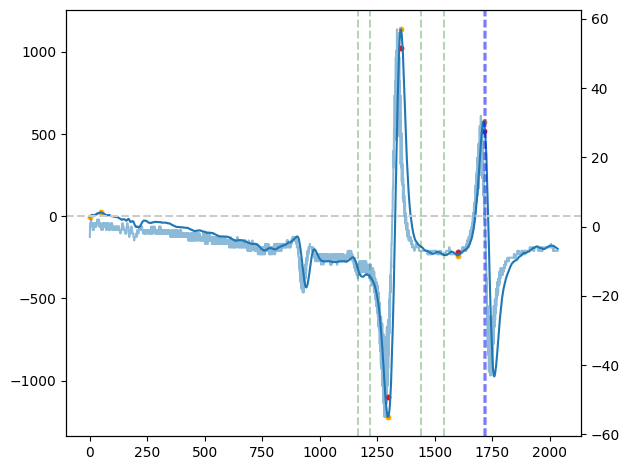

--- tolerance factor 0.85
original peaks [(1714, 574), (1601, -239), (1353, 1137), (1298, -1221), (50, 23), (0, -3)]
peaks filtered [(1714, 487.9), (1601, -203.15), (1353, 966.4499999999999), (1298, -1037.85)]
target peak idx 1714
final wait time 11
description is [(1168, -1037), (49, 966), (223, -203), (101, 487)]
lock_position 1715
lock_position 1721
lock_position 1724
lock_position 1724


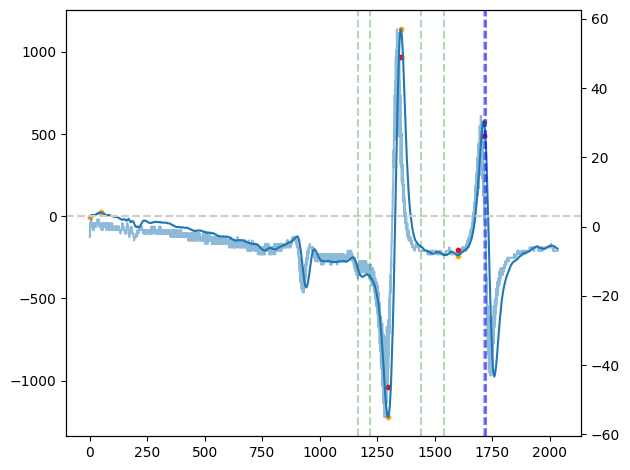

--- tolerance factor 0.8
original peaks [(1714, 574), (1601, -239), (1353, 1137), (1298, -1221), (50, 23), (0, -3)]
peaks filtered [(1714, 459.20000000000005), (1601, -191.20000000000002), (1353, 909.6), (1298, -976.8000000000001)]
target peak idx 1714
final wait time 12
description is [(1168, -976), (49, 909), (223, -191), (101, 459)]
lock_position 1715
lock_position 1721
lock_position 1723
lock_position 1723
lock_position 1722


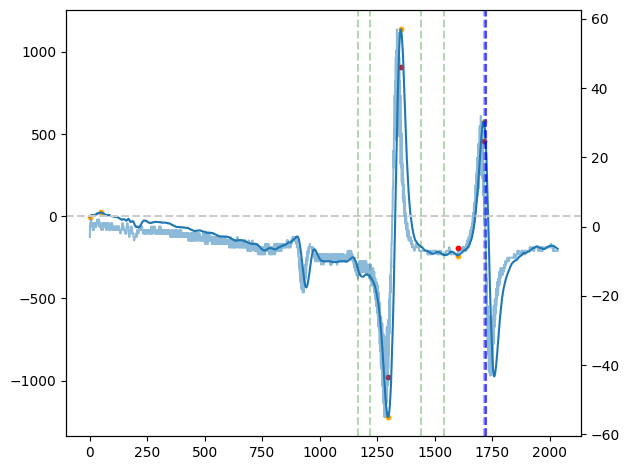

In [95]:
for tolerance_factor in [0.95,0.9,0.85,0.8,0.75,0.7]: #MODIFIED CODE. ORIGINAL [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]
        fig, ax0 = plt.subplots()
        ax1 = ax0.twinx() # Secondary y-axis
        ax0.plot(prepared_spectrum)
        ax1.plot(spectra_cropped[0], alpha=0.5)
        ax0.axhline(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
        #logger.debug(f"Try out tolerance {tolerance_factor}")
        peaks_filtered = [
            (peak_position, peak_height * tolerance_factor)
            for peak_position, peak_height in peaks #ORIGINAL CODE
        ] #reduces by 1-tolerance factor the height of the peaks ot see if they are significant

        # it is important to do the filtering that happens here after the previous
        # line as the previous line shrinks the values
        peaks_filtered = [
            (peak_position, peak_height)
            for peak_position, peak_height in peaks_filtered
            if abs(peak_height) > abs(y_scale * (1 - tolerance_factor))
        ] # keeps only significant peaks #ORIGINAL CODE
        print('--- tolerance factor', tolerance_factor)
        print('original peaks', peaks)
        print('peaks filtered', peaks_filtered)
    
        # now we have to find how much reducing the threshold influences our wait
        #time for the target peak (we will actually detect it earlier than it appears)
        target_peak_described_height = peaks_filtered[0][1]
        target_peak_idx = get_target_peak(prepared_spectrum, target_idxs_prepared) #MODIFIED CODE. Using also prepared indxs.
        print('target peak idx', target_peak_idx)
        #ax0.axvline(x=target_peak_idx, color='k', linestyle='--', alpha=0.5)

        for peak_position, peak_height in peaks:
            ax0.scatter(peak_position, peak_height, color='orange', s=10)

        for peak_position, peak_height in peaks_filtered:
            ax0.scatter(peak_position, peak_height, color='red', s=10)

        #the problem lies in the evaluation of final wait time. This should be the time to
        #wait from the detection of the last peak to the target peak
        current_idx = target_peak_idx #ORIGINAL CODE
        while True: #ORIGINAL CODE
            current_idx -= 1 #ORIGINAL CODE
            if np.abs(prepared_spectrum[current_idx]) < np.abs(
                target_peak_described_height
            ): #this is triggered in the first index to the left of the target
            #peak that is below the described height
                break
        final_wait_time = target_peak_idx - current_idx #ORIGINAL CODE
        #logger.debug(f"final wait time is {final_wait_time} samples")
        print('final wait time', final_wait_time)

        description = [] #ORIGINAL CODE

        last_peak_position = 0 #ORIGINAL CODE
        for peak_position, peak_height in list(reversed(peaks_filtered)):
            # TODO: this .9 factor is very arbitrary.
            description.append(
                (int(0.9 * (peak_position - last_peak_position)), int(peak_height))
            )
            last_peak_position = peak_position
        print('description is', description)

        counter = 0
        for x in description:
            counter += x[0]
            ax0.axvline(counter, color='g', linestyle='--', alpha=0.3)

        # test whether description works fine for every recorded spectrum
        does_work = True
        for spectrum, lock_region in zip(spectra, lock_regions):
            try:
                lock_position = get_lock_position_from_autolock_instructions(
                    spectrum, description, time_scale, spectra_cropped[0], final_wait_time
                ) #MODIFIED CODE. Using spectra_cropped[0] instead of spectra[0]
                print('lock_position', lock_position)
                ax0.axvline(x=lock_position, color='b', linestyle='--', alpha=0.3)
                if not lock_region[0] <= lock_position <= lock_region[1]:
                    print('LockPositionNotFound')

            except:
                does_work = False
        plt.tight_layout()
        plt.show()

        if does_work:
            break